# Theta-Gamma Network (in Brian)
Jupyter Notebook of the Theta-Gamma Spiking Network using Izhikevich neurons for phase coding of place cell-like activity.

Run the cells sequentially.  Adjust **`DURATION`** or set **`USE_CUDA = True`** to run on GPU (requires *brian2cuda*).

In [1]:
%matplotlib inline
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, sosfiltfilt, welch, hilbert
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')    # keep notebook output tidy
from scipy.stats import skewnorm
from brian2 import *

# --- Device selection -------------------------------------------------
USE_CUDA = False  # <- change to True if brian2cuda is installed
if USE_CUDA:
    import brian2cuda  # noqa: F401
    set_device('cuda_standalone')

defaultclock.dt = 0.1*ms

In [2]:
# --- Global constants --------------------------------------------------
from dataclasses import dataclass

DT = defaultclock.dt
DURATION = 10*second   # <-- tweak here

ENV_LENGTH = 1.0
OVERLAP = 0.7
SIGMA_PLACE = 0.2
RATE_PEAK = 160*Hz

N_SUBGROUPS = 10
M_EXC_PER_SUB = 20
N_EXC = N_SUBGROUPS * M_EXC_PER_SUB

N_SST_PER_SUB = 5
N_SST = N_SUBGROUPS * N_SST_PER_SUB

N_PV = 200

TAU_AMPA = 5*ms
TAU_NMDA = 100*ms
TAU_GABA_A = 10*ms
TAU_GABA_B = 100*ms
TAU_AHP_EXC = 150*ms

W = {
    'AMPA_IN': 0.2,
    'AMPA_SUBG': 0.5,
    'E_SST': 1.0,
    'SST_E': 4.0,
    'E_PV': 0.2,
    'PV_E': 0.35,
    'PV_SST': 0.0,
    'PV_PV': 0.0,
    'AHP': 8.0,
}

@dataclass(frozen=True)
class IzhiParams:
    a: float; b: float; c: float; d: float

params = {
    'exc': IzhiParams(0.02, 0.20, -65, 8),
    'sst': IzhiParams(0.02, 0.25, -65, 2),
    'pv':  IzhiParams(0.10, 0.20, -65, 2),
}

In [3]:
def compute_place_centers():
    centers = np.linspace(0, ENV_LENGTH, N_SUBGROUPS)
    centers = ENV_LENGTH/2 + OVERLAP*(centers - ENV_LENGTH/2)
    centers -= (centers - ENV_LENGTH/2)/3
    centers += ENV_LENGTH/4
    return centers

def place_rate_matrix(duration=DURATION):
    num_steps = int(duration/DT)
    t_vec = np.arange(num_steps) * DT
    speed = ENV_LENGTH/(duration/second)
    pos = speed*(t_vec/second)
    pos_grid = pos[None, :]
    center_grid = compute_place_centers()[:, None]
    rates_array = RATE_PEAK * skewnorm.pdf(pos_grid, a=-20, loc=center_grid, scale=SIGMA_PLACE)
    return rates_array

def build_neurons():
    # --- common equations -------------------------------------------------
    eqs_exc = '''
    dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn - I_AHP)/ms : 1
    du/dt = a*(b*v - u)/ms                                  : 1
    I_syn = I_AMPA + I_NMDA - I_GABA_A - I_GABA_B           : 1
    dI_AMPA/dt = -I_AMPA/TAU_AMPA                           : 1
    dI_NMDA/dt = -I_NMDA/TAU_NMDA                           : 1
    dI_GABA_A/dt = -I_GABA_A/TAU_GABA_A                     : 1
    dI_GABA_B/dt = -I_GABA_B/TAU_GABA_B                     : 1
    dI_AHP/dt   = -I_AHP/TAU_AHP_EXC                        : 1
    a : 1
    b : 1
    '''
    eqs_inh = eqs_exc.replace('- I_AHP', '')  # same but no AHP term

    # ---------- Excitatory group -----------------------------------------
    reset_exc = 'v = -65; u += d_exc; I_AHP += w_AHP'
    G_exc = NeuronGroup(
        N_EXC, eqs_exc, threshold='v>=30', reset=reset_exc, method='euler',
        namespace={'d_exc': params['exc'].d,
                   'w_AHP': W['AHP']}
    )
    G_exc.v = params['exc'].c
    G_exc.u = 0
    G_exc.I_AHP = 0
    G_exc.a = params['exc'].a
    G_exc.b = params['exc'].b

    # ---------- SST group -------------------------------------------------
    reset_sst = 'v = -65; u += d_sst'
    G_sst = NeuronGroup(
        N_SST, eqs_inh, threshold='v>=30', reset=reset_sst, method='euler',
        namespace={'d_sst': params['sst'].d}
    )
    G_sst.v = params['sst'].c
    G_sst.u = 0
    G_sst.a = params['sst'].a
    G_sst.b = params['sst'].b

    # ---------- PV group --------------------------------------------------
    reset_pv = 'v = -65; u += d_pv'
    G_pv = NeuronGroup(
        N_PV, eqs_inh, threshold='v>=30', reset=reset_pv, method='euler',
        namespace={'d_pv': params['pv'].d}
    )
    G_pv.v = params['pv'].c
    G_pv.u = 0
    G_pv.a = params['pv'].a
    G_pv.b = params['pv'].b

    return G_exc, G_sst, G_pv

def build_place_inputs(rate_array, G_exc):
    """Poisson place cells → excitatory subgroups."""
    pg_list, syn_list = [], []
    for sg in range(N_SUBGROUPS):
        # ---------- timed firing rate ---------------------------------
        rate_ta = TimedArray(rate_array[sg], dt=DT)      # units: Hz
        PG = PoissonGroup(100, rates='rt(t)',            # <-- string expr
                          namespace={'rt': rate_ta})
        pg_list.append(PG)

        # ---------- synapse onto the matching E subgroup --------------
        start, end = sg*M_EXC_PER_SUB, (sg+1)*M_EXC_PER_SUB
        syn = Synapses(
            PG, G_exc[start:end],
            on_pre='I_AMPA_post += w_AMPA_IN',            # <-- symbol
            namespace={'w_AMPA_IN': W['AMPA_IN']}         # <-- inject value
        )
        syn.connect(p=0.8)
        syn_list.append(syn)

    return pg_list, syn_list

def build_synapses(G_exc, G_sst, G_pv):
    """Return *all* Synapses objects with their connections."""
    # ------------------------------------------------------------------
    # 1) AMPA within each excitatory subgroup
    # ------------------------------------------------------------------
    S_AMPA_subg = Synapses(
        G_exc, G_exc,
        on_pre='I_AMPA_post += w_AMPA_SUBG',
        namespace={'w_AMPA_SUBG': W['AMPA_SUBG']}
    )
    for sg in range(N_SUBGROUPS):
        idx = range(sg * M_EXC_PER_SUB, (sg + 1) * M_EXC_PER_SUB)
        S_AMPA_subg.connect(i=idx, j=idx)

    # ------------------------------------------------------------------
    # 2) Excitatory → SST (one E‑subgroup to its matching SST‑subgroup)
    # ------------------------------------------------------------------
    S_E_SST = Synapses(
        G_exc, G_sst,
        on_pre='I_AMPA_post += w_E_SST',
        namespace={'w_E_SST': W['E_SST']}
    )
    for sg in range(N_SUBGROUPS):
        exc = np.arange(sg*M_EXC_PER_SUB, (sg+1)*M_EXC_PER_SUB)
        sst = np.arange(sg*N_SST_PER_SUB, (sg+1)*N_SST_PER_SUB)
        pre  = np.repeat(exc, len(sst))
        post = np.tile(sst,  len(exc))
        S_E_SST.connect(i=pre, j=post)

    # ------------------------------------------------------------------
    # 3) SST → all *other* E subgroups (lateral inhibition)
    # ------------------------------------------------------------------
    S_SST_E = Synapses(
        G_sst, G_exc,
        on_pre='I_GABA_A_post += w_SST_E',
        namespace={'w_SST_E': W['SST_E']}
    )
    for sg in range(N_SUBGROUPS):
        sst = np.arange(sg*N_SST_PER_SUB, (sg+1)*N_SST_PER_SUB)
        for other in range(N_SUBGROUPS):
            if other == sg:
                continue
            exc = np.arange(other*M_EXC_PER_SUB, (other+1)*M_EXC_PER_SUB)
            pre  = np.repeat(sst, len(exc))
            post = np.tile(exc, len(sst))
            S_SST_E.connect(i=pre, j=post)

    # ------------------------------------------------------------------
    # 4) PV network (global low-frequency oscillation)
    # ------------------------------------------------------------------
    S_PV_PV = Synapses(
        G_pv, G_pv,
        on_pre='I_GABA_B_post += w_PV_PV',
        namespace={'w_PV_PV': W['PV_PV']}
    )
    S_PV_PV.connect(p=0.2)

    S_E_PV = Synapses(
        G_exc, G_pv,
        on_pre='I_AMPA_post += w_E_PV',
        namespace={'w_E_PV': W['E_PV']}
    )
    S_E_PV.connect(p=1)

    S_PV_E = Synapses(
        G_pv, G_exc,
        on_pre='I_GABA_B_post += w_PV_E',
        namespace={'w_PV_E': W['PV_E']}
    )
    S_PV_E.connect(p=1)

    S_PV_SST = Synapses(
        G_pv, G_sst,
        on_pre='I_GABA_B_post += w_PV_SST',
        namespace={'w_PV_SST': W['PV_SST']}
    )
    S_PV_SST.connect(p=1)

    # return *all* objects so you can do net.add(*synapses)
    return (S_AMPA_subg, S_E_SST, S_SST_E,
            S_PV_PV, S_E_PV, S_PV_E, S_PV_SST)

def build_monitors(G_exc, G_sst, G_pv):
    return [
        SpikeMonitor(G_exc, record=True),
        StateMonitor(G_exc, 'v', record=True, dt=0.5*ms),
        SpikeMonitor(G_sst, record=True),
        StateMonitor(G_sst, 'v', record=True, dt=0.5*ms),
        SpikeMonitor(G_pv, record=True),
        StateMonitor(G_pv, 'v', record=True, dt=0.5*ms),
        StateMonitor(G_pv, 'I_GABA_B', record=True),
    ]

In [4]:
start_scope()
G_exc, G_sst, G_pv = build_neurons()
rates_array = place_rate_matrix()
PG_list, S_PG_exc = build_place_inputs(rates_array, G_exc)
synapses = build_synapses(G_exc, G_sst, G_pv)
monitors = build_monitors(G_exc, G_sst, G_pv)

net = Network(G_exc, G_sst, G_pv, *PG_list, *S_PG_exc, *synapses, *monitors)
#net

In [5]:
print(f'Running simulation for {DURATION/second} s ...')
net.run(DURATION)
print('Done.')

Running simulation for 10.0 s ...
Done.


# Plots

In [6]:
plt.style.use('seaborn-v0_8-poster')

## Input place cell-like curves (Mehta 2022 Nature)

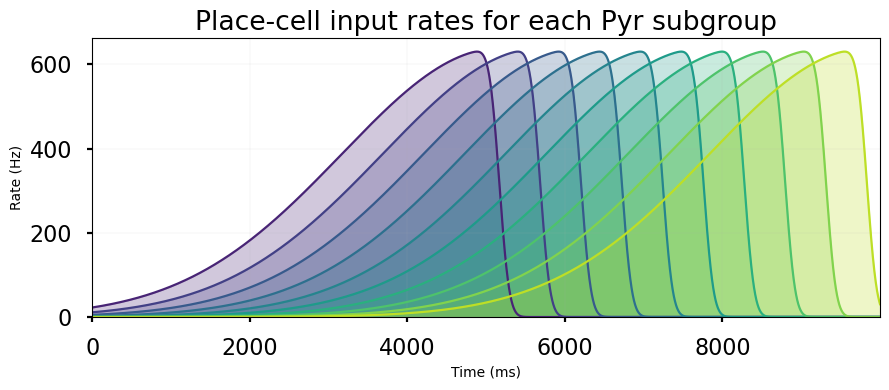

In [7]:
t_ms  = np.arange(rates_array.shape[1]) * defaultclock.dt / ms        # time axis [ms]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, rates_array.shape[0]))  # modern palette

plt.figure(figsize=(9, 4))
for i, c in enumerate(colors):
    curve = rates_array[i] / Hz                                       # to plain Hz
    plt.plot(t_ms, curve, color=c, lw=1.6)
    plt.fill_between(t_ms, 0, curve, color=c, alpha=0.25)

plt.title("Place‑cell input rates for each Pyr subgroup")
plt.xlabel("Time (ms)")
plt.ylabel("Rate (Hz)")
plt.xlim(t_ms[0], t_ms[-1])
plt.ylim(0, np.max(rates_array) / Hz * 1.05)
plt.grid(alpha=0.3, lw=0.3)
plt.tight_layout()
plt.show()

## Spike rasters and LFPs

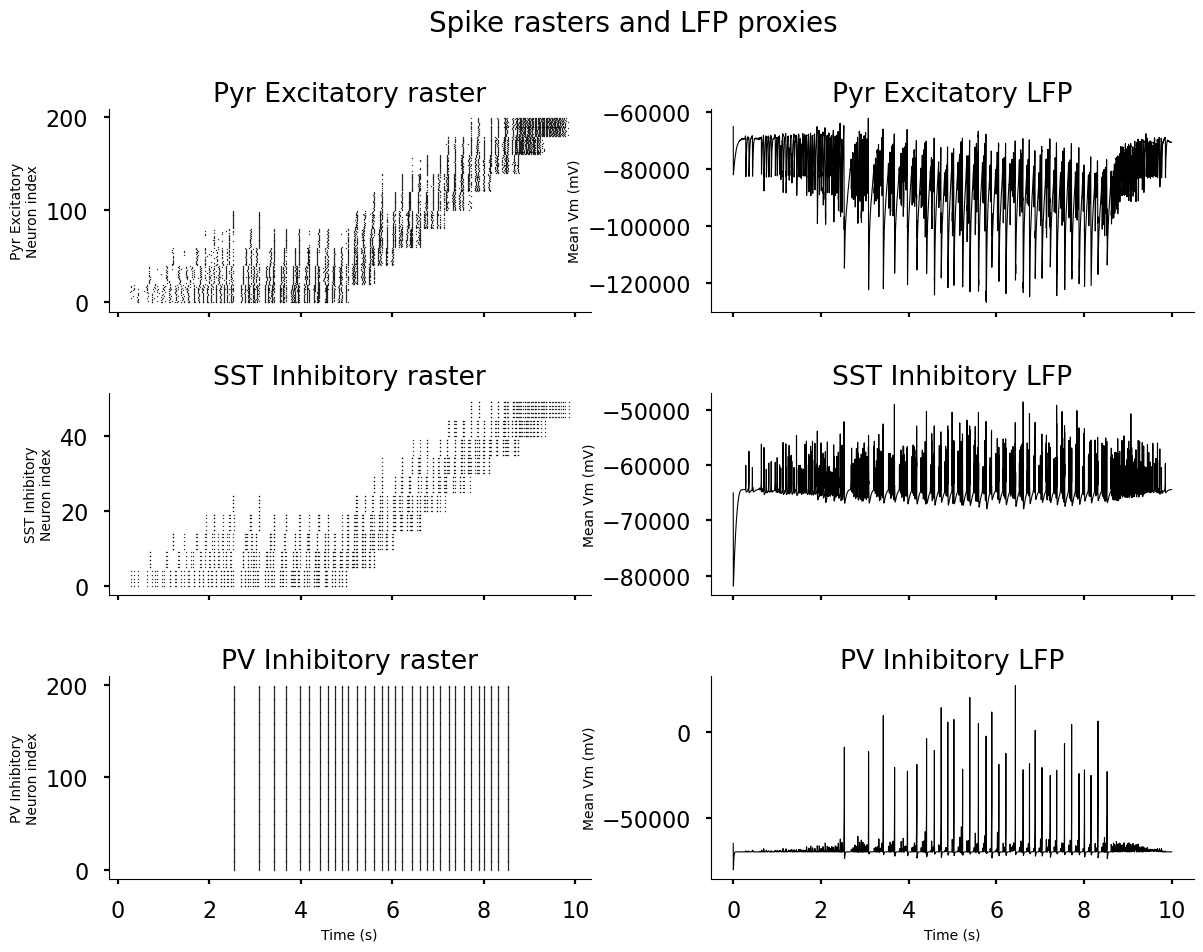

In [8]:
# ------------------------------------------------------------------
# Helper: mean‑membrane “LFP” for each population
# ------------------------------------------------------------------
time      = monitors[1].t / second                 # seconds
lfp_exc   = monitors[1].v.mean(axis=0) / mV        # mV
lfp_sst   = monitors[3].v.mean(axis=0) / mV
lfp_pv    = monitors[5].v.mean(axis=0) / mV

pop_info = [
    ('Pyr Excitatory',      monitors[0], lfp_exc),
    ('SST Inhibitory',  monitors[2], lfp_sst),
    ('PV Inhibitory',   monitors[4], lfp_pv)
]

# ------------------------------------------------------------------
# Figure: 3 rows × 2 columns (raster | LFP)
# ------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(14, 10), sharex='col',
    gridspec_kw={'hspace': 0.4, 'wspace': 0.25}
)

for row, (label, spk_mon, lfp_vec) in enumerate(pop_info):

    # --- Raster ----------------------------------------------------
    ax_rast = axes[row, 0]
    ax_rast.plot(spk_mon.t/second, spk_mon.i, '.k', markersize=2, alpha=0.8)
    ax_rast.set_ylabel(f'{label}\nNeuron index')
    ax_rast.set_title(f'{label} raster')
    ax_rast.spines[['top', 'right']].set_visible(False)
    #ax_rast.set_xlim(6, 8)

    # --- LFP trace -------------------------------------------------
    ax_lfp = axes[row, 1]
    ax_lfp.plot(time, lfp_vec, linewidth=0.8, color='k')
    ax_lfp.set_ylabel('Mean Vm (mV)')
    ax_lfp.set_title(f'{label} LFP')
    ax_lfp.spines[['top', 'right']].set_visible(False)
    #ax_lfp.set_xlim(6, 8)

# Shared x‑labels on bottom row
axes[-1, 0].set_xlabel('Time (s)')
axes[-1, 1].set_xlabel('Time (s)')

fig.suptitle('Spike rasters and LFP proxies', fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

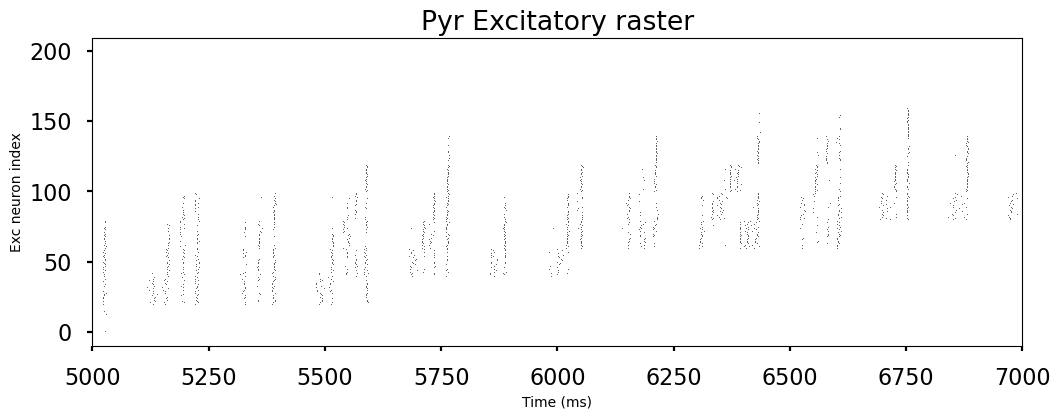

In [9]:
plt.figure(figsize=(12,4))
plt.plot(monitors[0].t/ms, monitors[0].i, '.k', ms=1)
plt.xlabel('Time (ms)'); plt.ylabel('Exc neuron index'); plt.title('Pyr Excitatory raster');
plt.xlim(5000, 7000)
plt.show()

In [10]:
# ---------------------------------------------------------------------
# --- 0) Small helpers -------------------------------------------------
# ---------------------------------------------------------------------

# Sampling rate of the StateMonitor traces (Hz)
FS = 1.0 / float(monitors[1].clock.dt / second)   # ← replace the old line
     # monitors[1] is the Exc‑Vm StateMonitor
THETA_BAND = (3., 8.)                # Hz
GAMMA_BAND = (30., 100.)             # Hz (broad gamma)

def bandpass(x, low, high, fs, order=4, detrend_mean=True):
    """
    Zero‑phase Butterworth band‑pass (stable SOS form).

    Parameters
    ----------
    x : 1‑D array‑like
        Signal.
    low, high : float
        Cut‑off frequencies in Hz.
    fs : float
        Sampling rate (Hz).
    order : int
        Filter *order* (overall, not per section). 4–6 is common.
    detrend_mean : bool
        Subtract mean before filtering to remove DC offset.
    """
    if detrend_mean:
        x = x - np.mean(x)

    nyq = fs * 0.5
    sos = butter(order, [low/nyq, high/nyq], btype='band', output='sos')
    return sosfiltfilt(sos, x)

## Power Spectra Density analysis

In [11]:
# =====================================================================
# >>>  Configure the analysis window  (in seconds)  <<<
#      Set tmin/tmax to None for “full trace”
# =====================================================================
tmin, tmax = 4.0, 8.0          # e.g. analyse 5 s → 8 s
# tmin, tmax = None, None      # ← uncomment for the complete signal


# ---------------------------------------------------------------------
# Helper: boolean mask for the chosen time slice
# ---------------------------------------------------------------------
if tmin is None and tmax is None:
    win_mask = slice(None)                       # keep everything
else:
    win_mask = np.ones_like(time, dtype=bool)
    if tmin is not None:
        win_mask &= time >= tmin
    if tmax is not None:
        win_mask &= time <= tmax

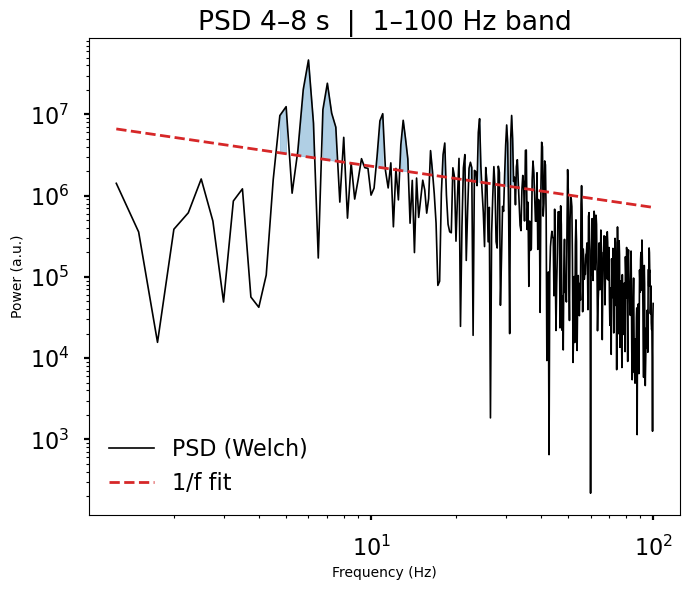

In [12]:
# ---------------------------------------------------------------------
# --- 1) PSD + 1/f fit  –  full‑area highlighting ---------------------
# ---------------------------------------------------------------------
def _one_over_f(f, a, b):
    return a / np.power(f, b)

def plot_psd_with_1overf(
        lfp, fs,
        tmin=None, tmax=None, t=None,
        freq_range=(1., 100.)
    ):
    """
    Welch PSD (restricted band) + 1/f fit + solid shading of all
    frequency ranges where PSD > fit.
    """
    f_low, f_high = freq_range

    # ---------- slice in time if needed -----------------------------
    if t is None:
        t = np.arange(len(lfp)) / fs
    if (tmin is not None) or (tmax is not None):
        keep = np.ones_like(lfp, dtype=bool)
        if tmin is not None:
            keep &= t >= tmin
        if tmax is not None:
            keep &= t <= tmax
        lfp = lfp[keep]

    # ---------- Welch PSD -------------------------------------------
    f, Pxx = welch(lfp, fs=fs, nperseg=2**13, noverlap=2**12,
                   window='hann', detrend='constant')
    band = (f >= f_low) & (f <= f_high)
    f, Pxx = f[band], Pxx[band]

    # ---------- 1/f fit (in‑band) -----------------------------------
    popt, _   = curve_fit(_one_over_f, f, Pxx,
                          p0=(Pxx.max(), 1.))
    fit_curve = _one_over_f(f, *popt)

    # ---------- Plot -------------------------------------------------
    plt.figure(figsize=(7,6))
    plt.loglog(f, Pxx, color='k', lw=1.2, label='PSD (Welch)')
    plt.loglog(f, fit_curve, '--', color='tab:red', lw=2, label='1/f fit')

    # ---------- Shade *all* regions where PSD > fit -----------------
    above = Pxx > fit_curve
    # find contiguous regions of "above"
    starts = np.where(np.diff(np.concatenate(([0], above.astype(int)))) == 1)[0]
    ends   = np.where(np.diff(np.concatenate((above.astype(int), [0]))) == -1)[0]

    for s, e in zip(starts, ends):
        plt.fill_between(f[s:e+1], fit_curve[s:e+1], Pxx[s:e+1],
                         color='tab:blue', alpha=0.35)

    # ---------- labels ----------------------------------------------
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (a.u.)')
    wlabel = (f"{tmin if tmin is not None else 0:g}–"
              f"{tmax if tmax is not None else t[-1]:g} s") \
             if (tmin is not None or tmax is not None) else "full trace"
    plt.title(f'PSD {wlabel}  |  {f_low:g}–{f_high:g} Hz band')
    plt.legend(frameon=False)
    plt.tight_layout()

    
plot_psd_with_1overf(lfp_exc, FS, tmin=tmin, tmax=tmax, freq_range=(1, 100))

## Theta-Gamma phase amplitude coupling

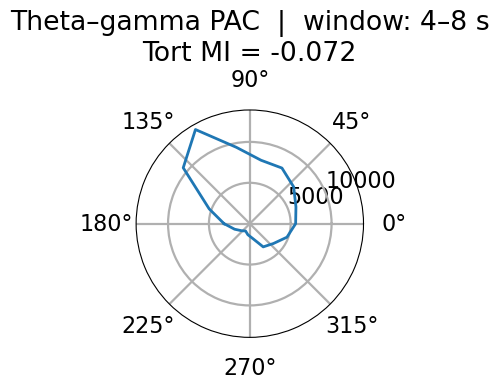

In [13]:
# =====================================================================
# --- 2) Theta–gamma Phase–Amplitude Coupling (Tort MI) ---------------
# =====================================================================
# Apply window --------------------------------------------------------
lfp_win = lfp_exc[win_mask]

def tort_MI(phase, amp, n_bins=18):
    """Modulation‑Index from Tort et al. (2010)."""
    bins   = np.linspace(-np.pi, np.pi, n_bins+1)
    digit  = np.digitize(phase, bins) - 1
    # mean amp per phase bin
    mean_amp = np.array([amp[digit == k].mean() if np.any(digit==k) else 0
                         for k in range(n_bins)])
    mean_amp += 1e-6                        # avoid log(0)
    mean_amp /= mean_amp.sum()              # normalise → p(j)
    return (entropy(mean_amp, base=np.e) - np.log(n_bins)) / np.log(n_bins)

def phase_amp_hist(theta_phase, gamma_amp, n_bins=18):
    bins = np.linspace(-np.pi, np.pi, n_bins+1)
    digit = np.digitize(theta_phase, bins) - 1
    mean_amp = np.array([gamma_amp[digit == k].mean() if np.any(digit==k) else 0
                         for k in range(n_bins)])
    return bins[:-1], mean_amp

# Band‑pass filtering -------------------------------------------------
theta = bandpass(lfp_win, *THETA_BAND, fs=FS)
gamma = bandpass(lfp_win, *GAMMA_BAND, fs=FS)
theta_phase = np.angle(hilbert(theta))
gamma_env   = np.abs(hilbert(gamma))

# Tort MI and polar histogram ----------------------------------------
MI = tort_MI(theta_phase, gamma_env)
bins, mean_amp = phase_amp_hist(theta_phase, gamma_env)

plt.figure(figsize=(6,4))
plt.polar(np.append(bins, bins[0]), np.append(mean_amp, mean_amp[0]), lw=2)
lbl = (f"{tmin if tmin is not None else 0:g}–"
       f"{tmax if tmax is not None else time[-1]:g} s")
plt.title(f"Theta–gamma PAC  |  window: {lbl}\nTort MI = {MI:.3f}")
plt.tight_layout()

## Phase precession

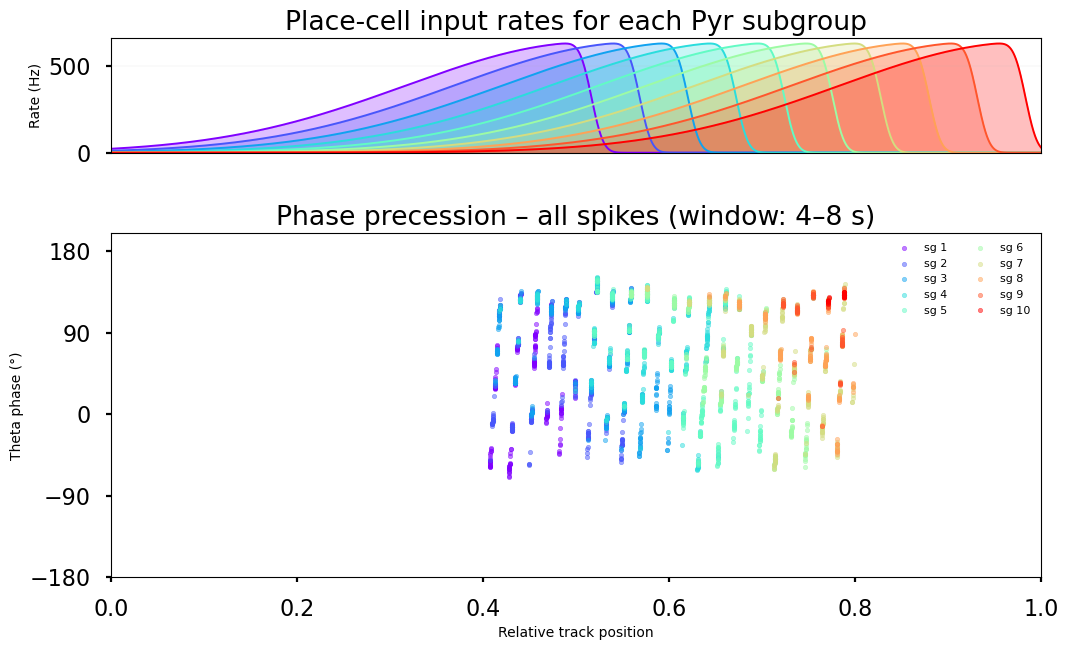

In [14]:
# =====================================================================
# --------  3) Phase precession  +  compact rate overlay  -------------
# =====================================================================

# ---------------------------------------------------------------------
# Helper: circular‑linear regression
#   φ(x) = α + β x  (mod 2π)    → returns (α, β) in radians
# ---------------------------------------------------------------------
def circ_lin_fit(x, phi):
    x   = np.asarray(x, float)
    phi = np.asarray(phi, float)

    def neg_R(beta):
        R = np.exp(1j * (phi - beta * x)).mean()
        return -np.abs(R)

    res  = opt.minimize_scalar(neg_R, bounds=(-4*pi, 4*pi), method='bounded')
    beta = res.x
    alpha = np.angle(np.exp(1j * (phi - beta * x)).mean())
    return alpha, beta


# ---------------------------------------------------------------------
# a) Theta phase (3–8 Hz) for the full trace
# ---------------------------------------------------------------------
theta_phase_ts = np.angle(hilbert(bandpass(lfp_exc, 3., 8., fs=FS)))

# ---------------------------------------------------------------------
# b) Relative position along the track (0‑1)
# ---------------------------------------------------------------------
speed      = ENV_LENGTH / (DURATION/second)
pos_ts     = speed * time
rel_pos_ts = pos_ts / ENV_LENGTH

# ---------------------------------------------------------------------
# c) Gather all spikes inside the analysis window, grouped by subgroup
# ---------------------------------------------------------------------
phases_by_sg = [[] for _ in range(N_SUBGROUPS)]
pos_by_sg    = [[] for _ in range(N_SUBGROUPS)]

for n_idx, t_spk in zip(monitors[0].i, monitors[0].t/second):
    if (tmin is not None and t_spk < tmin) or (tmax is not None and t_spk > tmax):
        continue
    sg      = int(n_idx) // M_EXC_PER_SUB
    ts_idx  = np.searchsorted(time, t_spk)
    phases_by_sg[sg].append(theta_phase_ts[ts_idx])
    pos_by_sg[sg].append(rel_pos_ts[ts_idx])

# ---------------------------------------------------------------------
# d) Rainbow colour palette (same for both panels)
# ---------------------------------------------------------------------
colors = plt.cm.rainbow(np.linspace(0.00, 1.00, N_SUBGROUPS))

# ---------------------------------------------------------------------
# e) Figure: small rate panel + tall phase‑precession panel
# ---------------------------------------------------------------------
fig, (ax_rates, ax_phase) = plt.subplots(
    2, 1, figsize=(12, 7),
    gridspec_kw={'hspace': 0.35, 'height_ratios': [1, 3]}
)

# -------------------------  (1) input‑rate panel  --------------------
t_ms = np.arange(rates_array.shape[1]) * defaultclock.dt / ms
for sg, col in enumerate(colors):
    curve = rates_array[sg] / Hz
    ax_rates.plot(t_ms, curve, lw=1.4, color=col)
    ax_rates.fill_between(t_ms, 0, curve, color=col, alpha=0.25)
ax_rates.set_title("Place‑cell input rates for each Pyr subgroup")
ax_rates.set_ylabel("Rate (Hz)")
ax_rates.set_xlim(t_ms[0], t_ms[-1])
ax_rates.set_ylim(0, (rates_array.max()/Hz) * 1.05)
ax_rates.set_xticks([])
ax_rates.grid(alpha=0.3, lw=0.3)

# -------------------------  (2) phase‑precession panel  --------------
lbl = (f"{tmin if tmin is not None else 0:g}–"
       f"{tmax if tmax is not None else time[-1]:g} s") \
      if (tmin is not None or tmax is not None) else "full trace"
ax_phase.set_title(f"Phase precession – all spikes (window: {lbl})")

for sg, col in enumerate(colors):
    if not phases_by_sg[sg]:
        continue

    pos_arr   = np.asarray(pos_by_sg[sg])
    phase_rad = np.asarray(phases_by_sg[sg])

    # ----- scatter ---------------------------------------------------
    ax_phase.scatter(pos_arr, np.degrees(phase_rad),
                     s=10, alpha=0.5, color=col, label=f'sg {sg+1}')

# cosmetics
ax_phase.set_xlabel("Relative track position")
ax_phase.set_ylabel("Theta phase (°)")
ax_phase.set_xlim(0, 1)
ax_phase.set_ylim(-180, 200)
ax_phase.set_yticks([-180, -90, 0, 90, 180])
ax_phase.legend(ncol=2, fontsize=8, frameon=False)

plt.tight_layout()
plt.show()

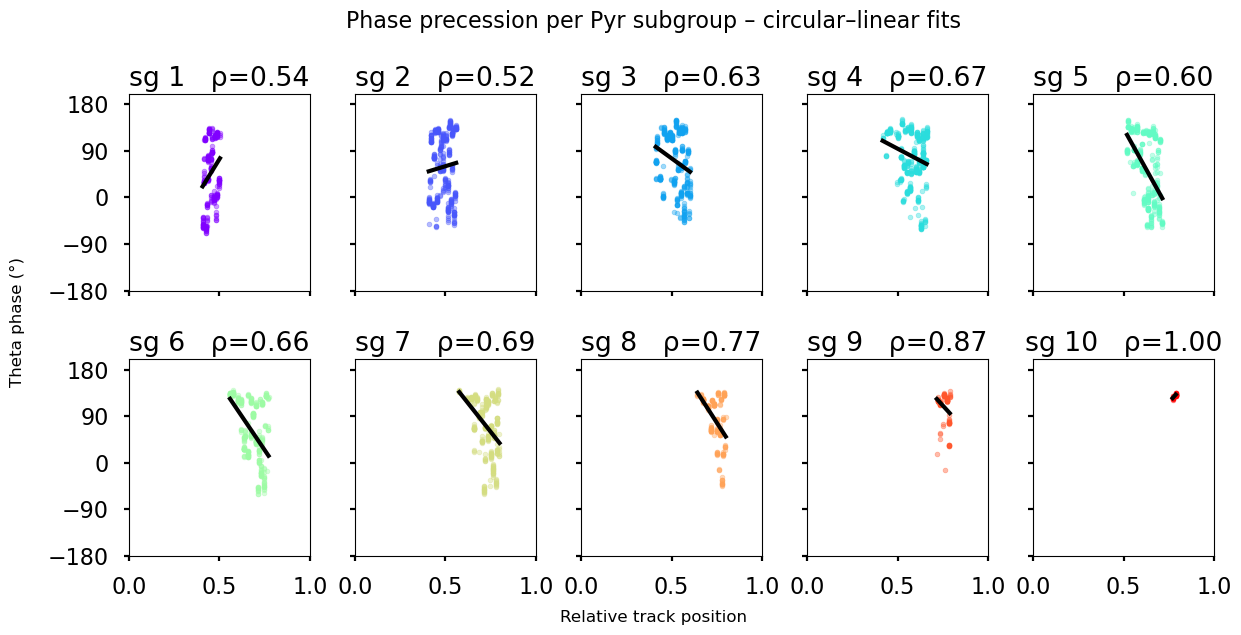

In [15]:
# =====================================================================
#  Circular‑linear fits per subgroup – with correlation strength ρ
# =====================================================================
from numpy import pi
import scipy.optimize as opt

def circ_lin_fit(x, phi):
    """
    Circular‑linear regression
        phi(x) = alpha + beta * x    (mod 2π)
    Returns alpha, beta (radians) and the resultant‑vector length ρ.
    """
    x   = np.asarray(x, float)
    phi = np.asarray(phi, float)

    def neg_R(beta):
        R = np.exp(1j * (phi - beta * x)).mean()
        return -np.abs(R)

    res  = opt.minimize_scalar(neg_R, bounds=(-4*pi, 4*pi), method='bounded')
    beta = res.x
    Rvec = np.exp(1j * (phi - beta * x)).mean()
    rho  = np.abs(Rvec)                          # correlation strength
    alpha = np.angle(Rvec)
    return alpha, beta, rho


# ---------------------------------------------------------------------
# create figure -------------------------------------------------------
fig, axes = plt.subplots(
    2, 5, figsize=(14, 6),
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0.35, 'wspace': 0.25}
)

for sg in range(N_SUBGROUPS):
    ax   = axes.flat[sg]
    col  = colors[sg]                          # rainbow palette colour

    if not phases_by_sg[sg]:                   # no spikes in this window
        ax.text(0.5, 0.5, 'no spikes', ha='center', va='center')
        ax.set_title(f'sg {sg+1}')
        continue

    # data ------------------------------------------------------------
    pos_arr = np.asarray(pos_by_sg[sg])
    phi_rad = np.asarray(phases_by_sg[sg])

    ax.scatter(pos_arr, np.degrees(phi_rad),
               s=12, alpha=0.4, color=col)

    # circular‑linear fit --------------------------------------------
    alpha_hat, beta_hat, rho = circ_lin_fit(pos_arr, phi_rad)

    # restrict line to observed position span
    x_fit = np.linspace(pos_arr.min(), pos_arr.max(), 120)
    y_fit = alpha_hat + beta_hat * x_fit
    y_fit_wrapped = (y_fit + pi) % (2*pi) - pi        # wrap to (−π, π)

    ax.plot(x_fit, np.degrees(y_fit_wrapped), lw=3, color='k')

    # panel cosmetics -------------------------------------------------
    ax.set_title(f'sg {sg+1}   ρ={rho:.2f}')
    ax.set_xlim(0, 1)
    ax.set_ylim(-180, 200)
    ax.set_xticks([0, 0.5, 1.0])
    ax.set_yticks([-180, -90, 0, 90, 180])

# unified labels
fig.text(0.5, 0., 'Relative track position', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Theta phase (°)', va='center', rotation='vertical',
         fontsize=12)
fig.suptitle('Phase precession per Pyr subgroup – circular–linear fits',
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Sanity checks

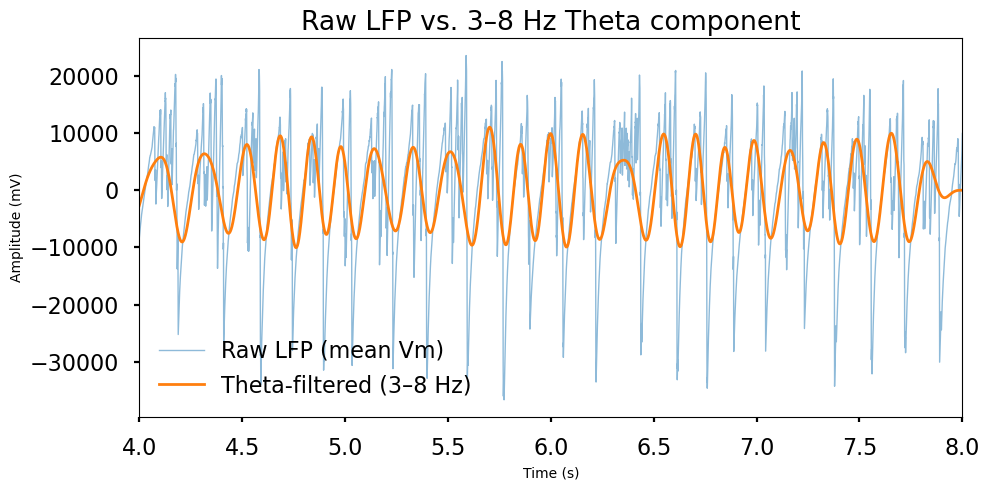

In [16]:
# ---------------------------------------------------------------------
# Sanity check: raw LFP vs. 3–8 Hz theta‑band trace -------------------
# ---------------------------------------------------------------------
# 1) Build the time axis that matches *theta*.
#    If you used a window (win_mask), theta == lfp_exc[win_mask] filtered
#    so we reuse that mask; otherwise it’s the full trace.
if "win_mask" in locals():
    t_theta = time[win_mask]          # windowed axis
    lfp_raw = lfp_exc[win_mask]       # matching slice of raw LFP
else:
    t_theta = time                    # full axis
    lfp_raw = lfp_exc                 # full raw LFP

# 2) Plot ----------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(t_theta, lfp_raw-np.mean(lfp_raw), label='Raw LFP (mean Vm)', alpha=0.5, lw=1)
plt.plot(t_theta, theta,  label='Theta‑filtered (3–8 Hz)', lw=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Raw LFP vs. 3–8 Hz Theta component')
plt.xlim(t_theta[0], t_theta[-1])
plt.legend(frameon=False)
plt.tight_layout()